In [1]:
import tensorflow as tf

In [2]:
import requests
r = requests.get('https://api.ipify.org?format=json')
j = r.json()
print(j)

{'ip': '34.66.62.154'}


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train /255.0, x_test / 255.0

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
x_train = np.expand_dims(x_train , -1)
x_test = np.expand_dims(x_test, -1)

In [6]:
K = len(set(y_train))
print(K)

10


In [7]:
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3,3), strides=2, activation = 'relu')(i)
x = Conv2D(64, (3,3), strides=2, activation = 'relu')(x)
x = Conv2D(128, (3,3), strides=2, activation = 'relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation = 'softmax')(x)

model = Model(i,x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656

In [8]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
r = model.fit(
    x_train, y_train, validation_data=(x_test, y_test), epochs =15
)

Epoch 1/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5253 - accuracy: 0.8049 - val_loss: 0.3991 - val_accuracy: 0.8503
Epoch 2/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3643 - accuracy: 0.8620 - val_loss: 0.3372 - val_accuracy: 0.8760
Epoch 3/15
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3138 - accuracy: 0.8818 - val_loss: 0.3417 - val_accuracy: 0.8732
Epoch 4/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2807 - accuracy: 0.8945 - val_loss: 0.3059 - val_accuracy: 0.8871
Epoch 5/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2567 - accuracy: 0.9031 - val_loss: 0.2835 - val_accuracy: 0.8948
Epoch 6/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2332 - accuracy: 0.9112 - val_loss: 0.3068 - val_accuracy: 0.8887
Epoch 7/15
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2173 - accuracy: 0.9166 - val_loss: 0.3031 - val_ac

In [9]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 168
drwxr-xr-x 2 root root   4096 Jul  6 18:56 assets
-rw-r--r-- 1 root root 161709 Jul  6 18:56 saved_model.pb
drwxr-xr-x 2 root root   4096 Jul  6 18:56 variables


In [10]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0706 18:57:00.430762 140462144526208 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/re

In [11]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  20020      0 --:--:-- --:--:-- --:--:-- 20020
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://developer.

In [12]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 52 not upgraded.
Need to get 187 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.2.0 [187 MB]
Fetched 187 MB in 3s (68.8 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.2.0_all.deb ...
Unpacking tensorflow-model-server (2.2.0) ...
Setting up tensorflow-model-server (2.2.0) ...


In [13]:
os.environ['MODEL_DIR'] = MODEL_DIR

In [14]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [15]:
!tail server.log

2020-07-06 18:57:21.916808: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-07-06 18:57:21.936478: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2020-07-06 18:57:21.981951: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /tmp/1
2020-07-06 18:57:21.991912: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:364] SavedModel load for tags { serve }; Status: success: OK. Took 77793 microseconds.
2020-07-06 18:57:21.993069: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-07-06 18:57:21.993208: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
2020-07-06 18:57:21.9946

In [16]:
labels = ''' T-shirt
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

In [17]:
def show(idx, title):
    plt.figure()
    plt.imshow(x_test[idx].reshape(28,28), cmap = 'gray')
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size':16})

    i = np.random.randint(0, len(x_test))
    show(i, labels[y_test[i]])

In [18]:
import json
data = json.dumps({'signature_name': 'serving_default', 'instances': x_test[0:3].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

In [19]:
headers  = {'content-type': 'application/data'}
r = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
j = r.json()
print(j.keys())
print(j)

dict_keys(['predictions'])
{'predictions': [[2.62612604e-14, 7.83874e-15, 7.48879955e-15, 1.17403385e-16, 1.10171797e-14, 3.23058524e-10, 1.55158953e-14, 1.26300151e-07, 1.33328672e-15, 0.999999881], [0.0244213864, 7.49044403e-12, 0.974687755, 0.000211293649, 0.000526352436, 4.80463759e-13, 0.000153218411, 1.30083856e-14, 1.95441219e-09, 1.37640528e-12], [5.37694964e-30, 1.0, 6.78047745e-37, 2.30902131e-35, 3.45588559e-36, 0.0, 3.30919379e-38, 0.0, 0.0, 0.0]]}


In [20]:
pred = np.array(j['predictions'])
print(pred.shape)

(3, 10)


In [21]:
pred = pred.argmax(axis=1)

In [22]:
pred = [labels[i] for i in pred]
print(pred)

['Ankle boot', 'Pullover', 'Trouser']


In [23]:
actual = [labels[i] for i in y_test[:3]]
print(actual)

['Ankle boot', 'Pullover', 'Trouser']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


RecursionError: ignored

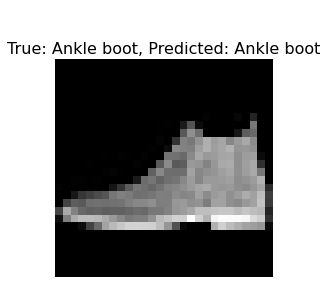

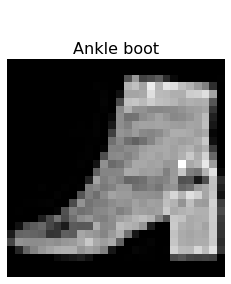

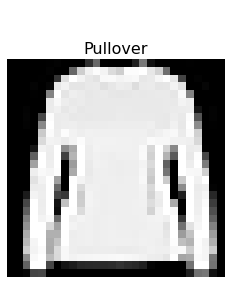

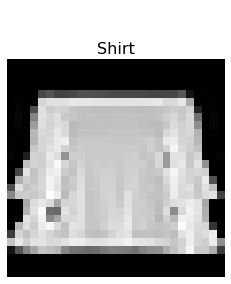

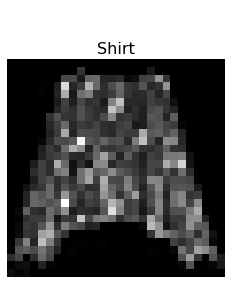

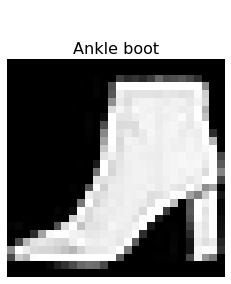

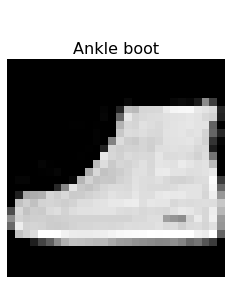

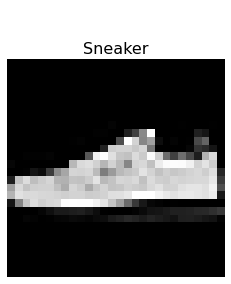

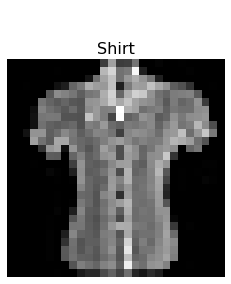

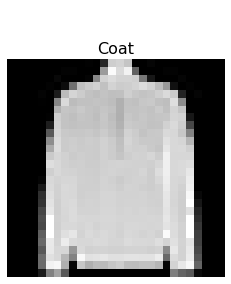

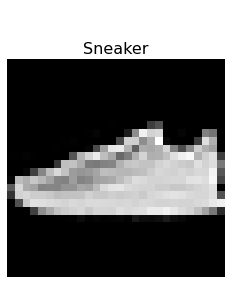

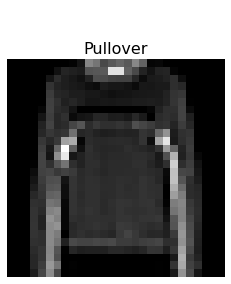

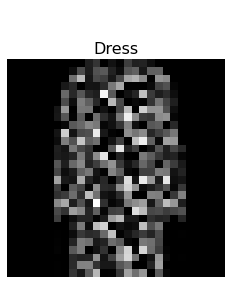

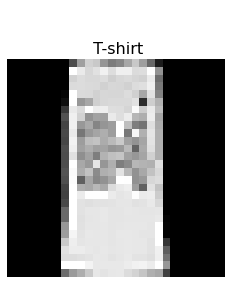

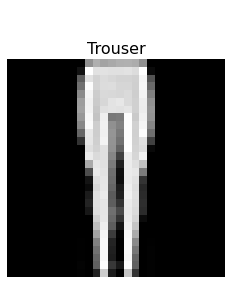

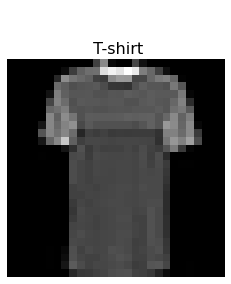

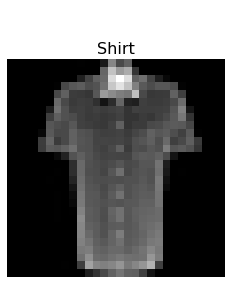

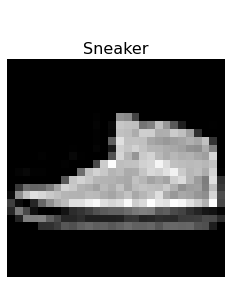

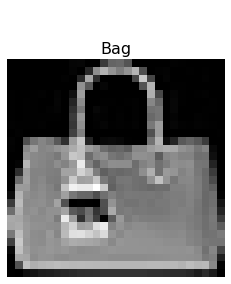

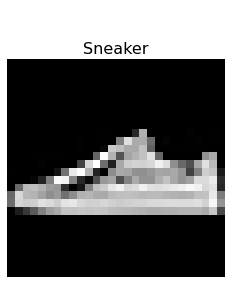

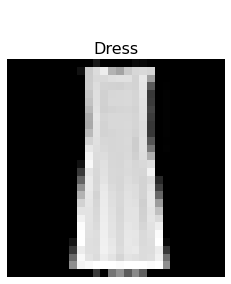

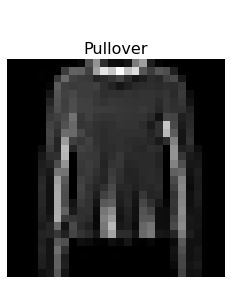

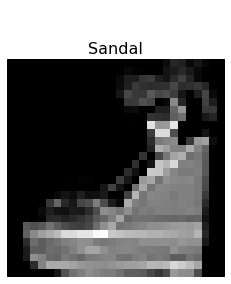

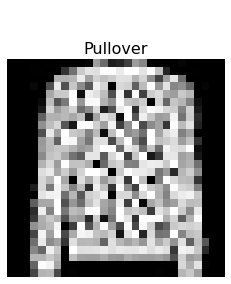

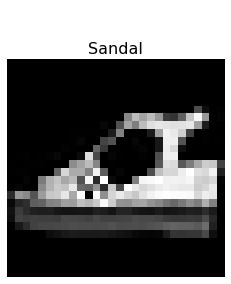

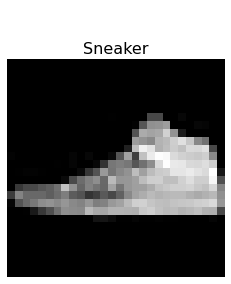

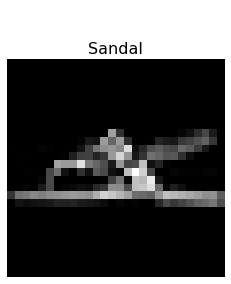

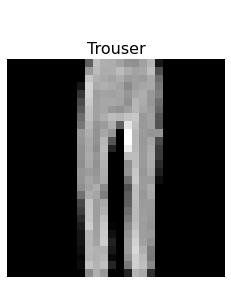

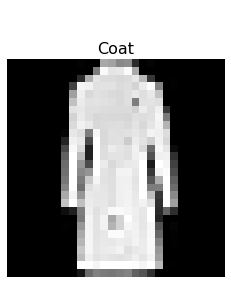

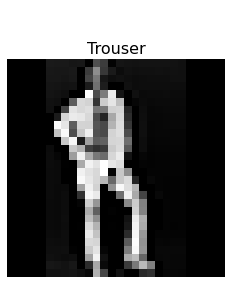

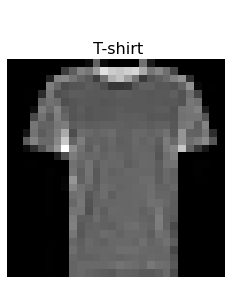

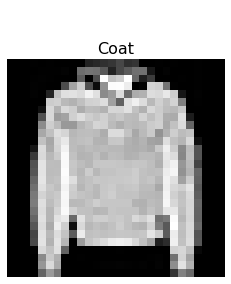

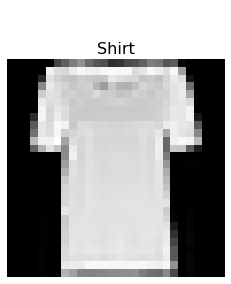

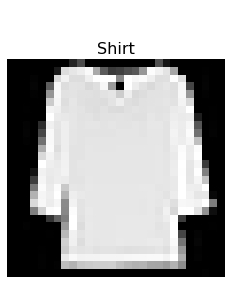

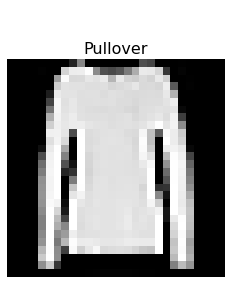

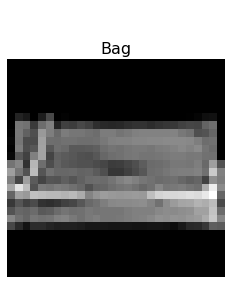

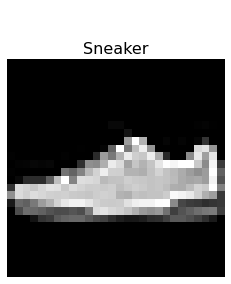

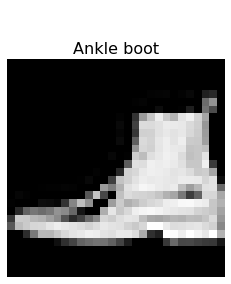

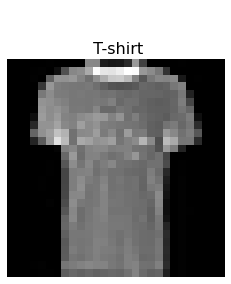

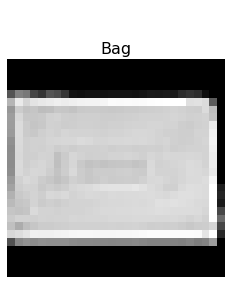

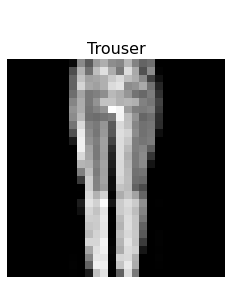

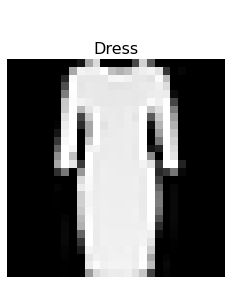

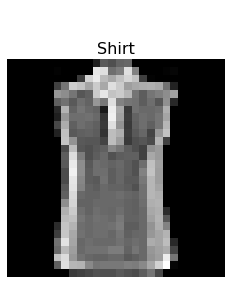

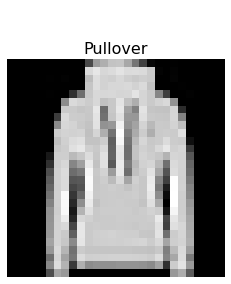

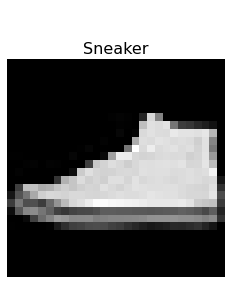

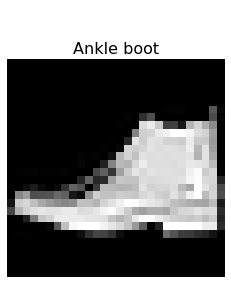

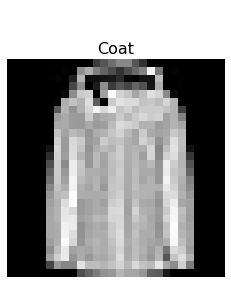

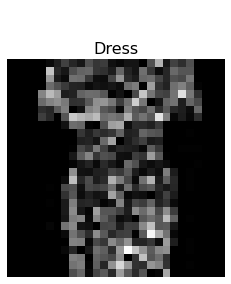

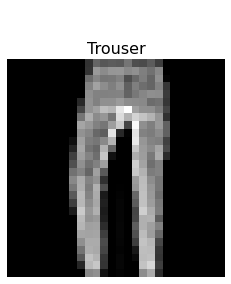

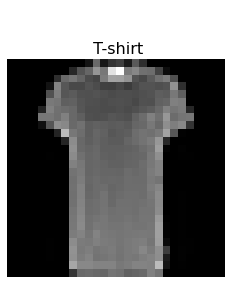

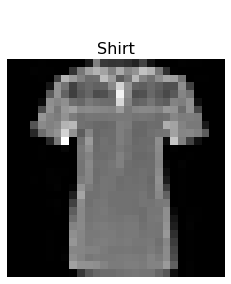

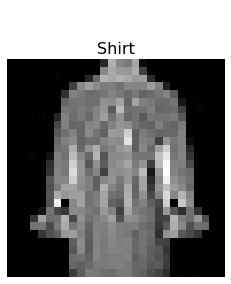

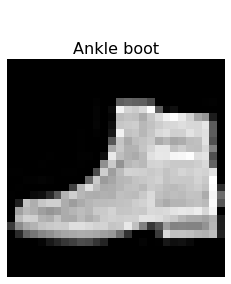

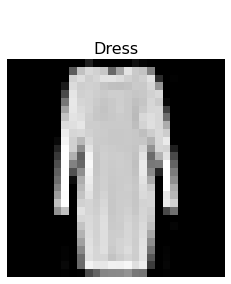

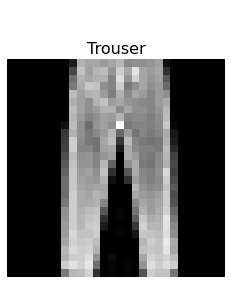

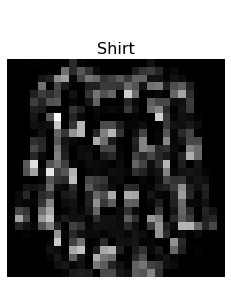

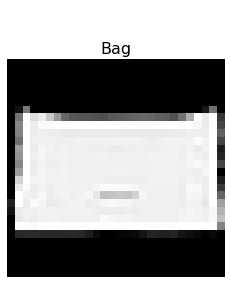

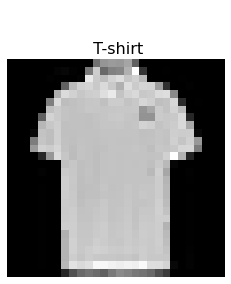

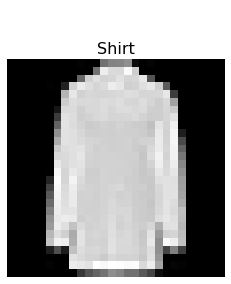

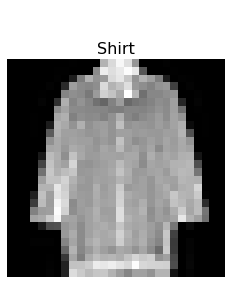

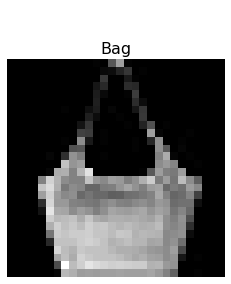

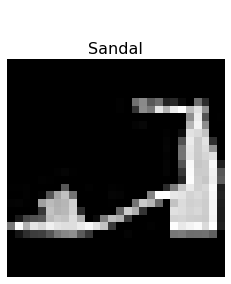

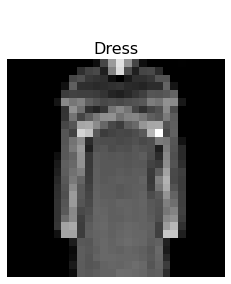

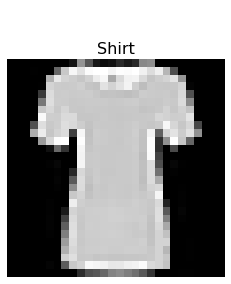

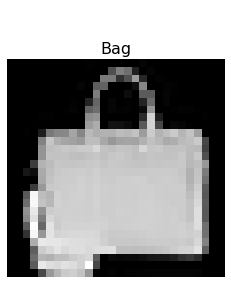

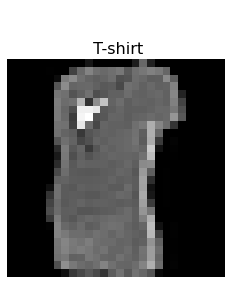

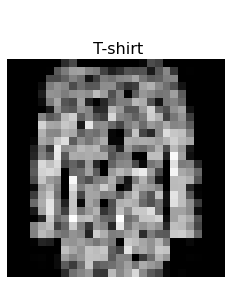

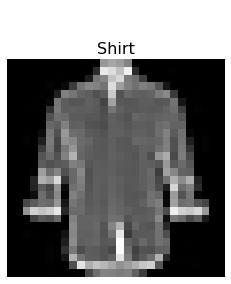

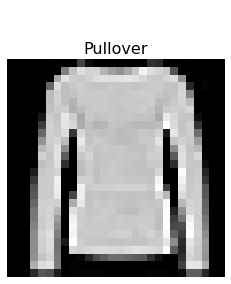

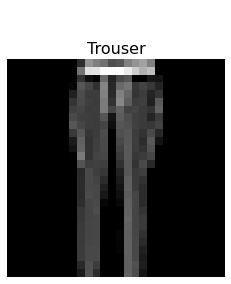

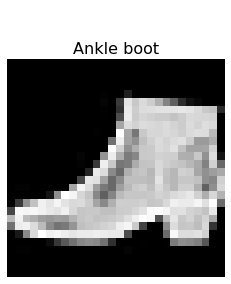

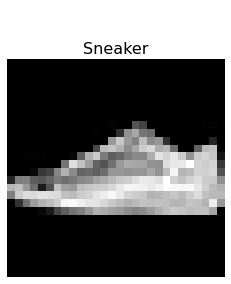

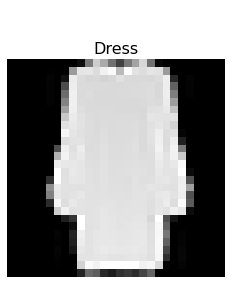

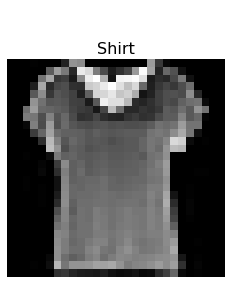

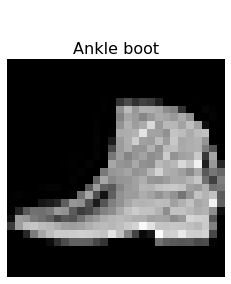

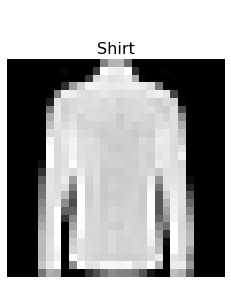

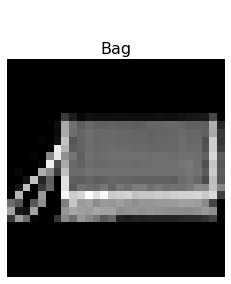

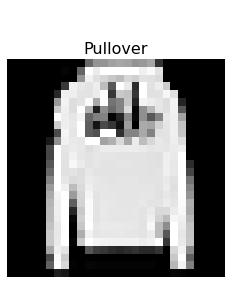

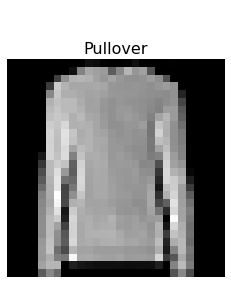

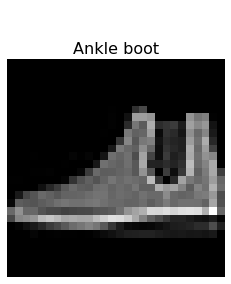

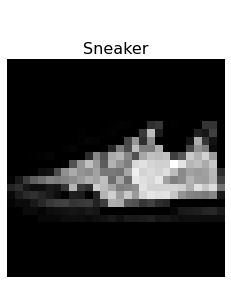

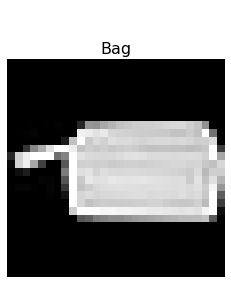

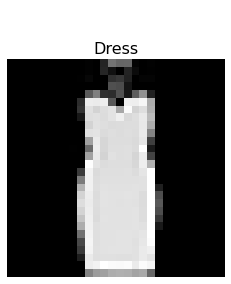

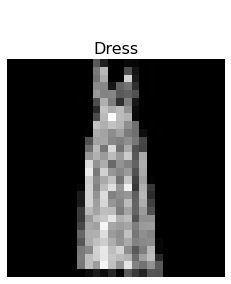

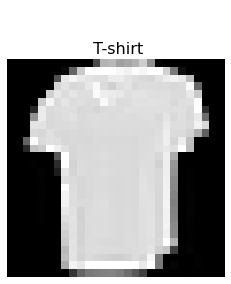

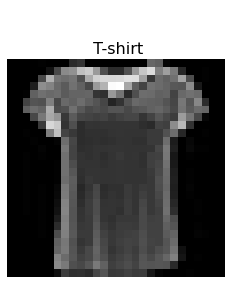

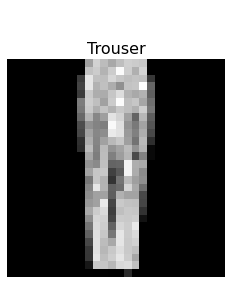

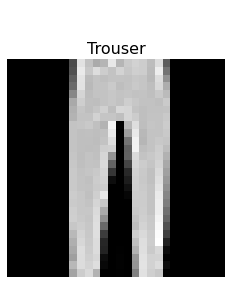

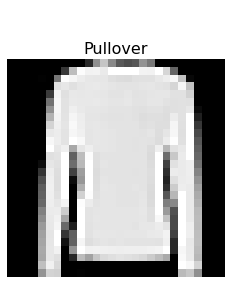

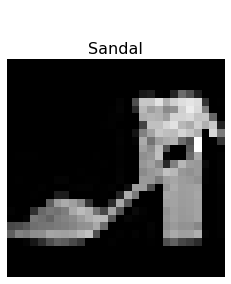

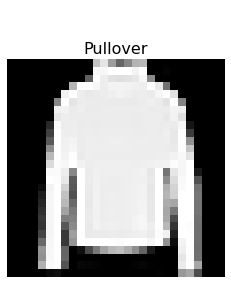

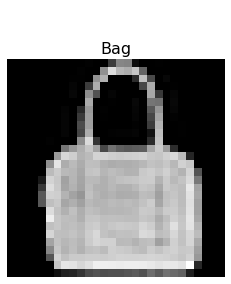

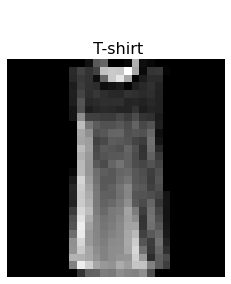

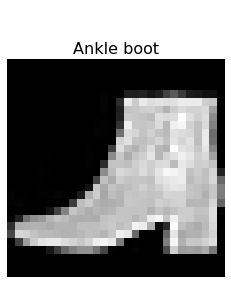

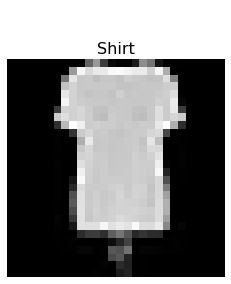

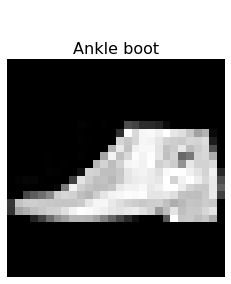

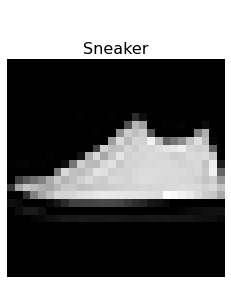

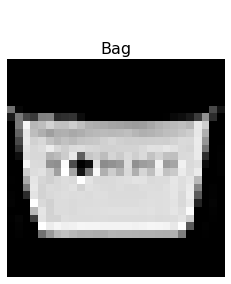

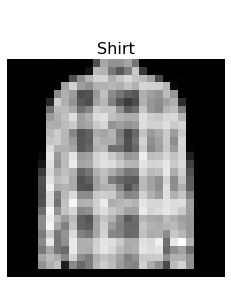

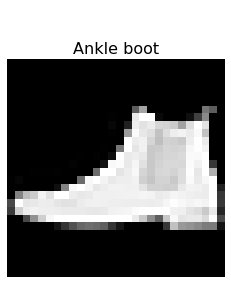

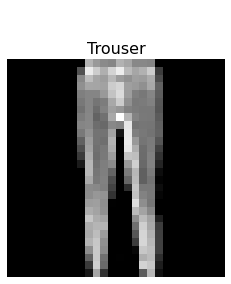

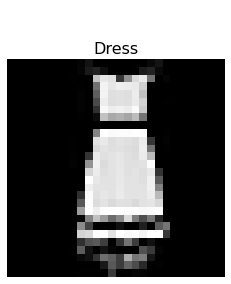

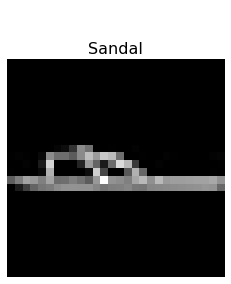

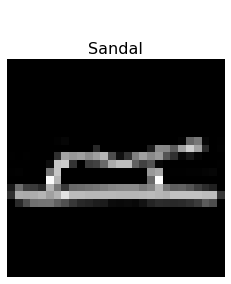

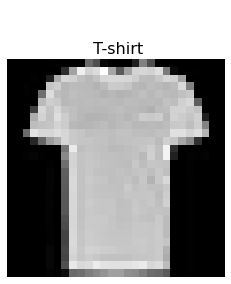

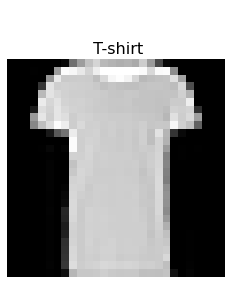

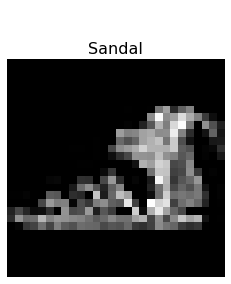

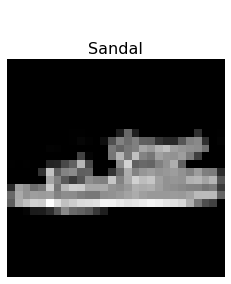

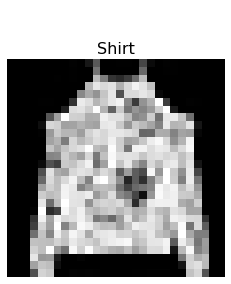

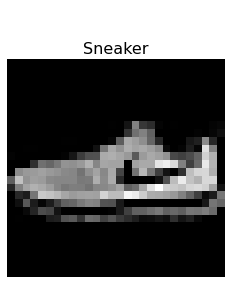

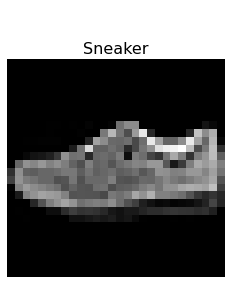

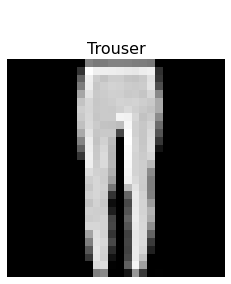

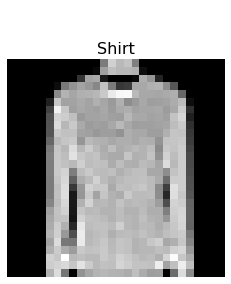

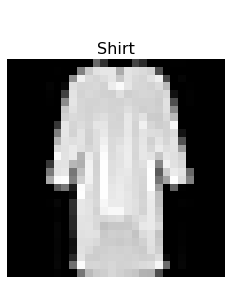

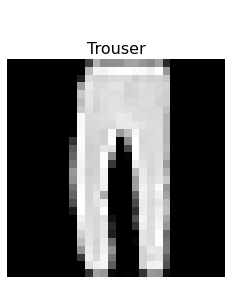

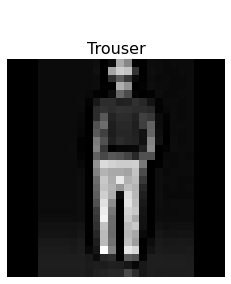

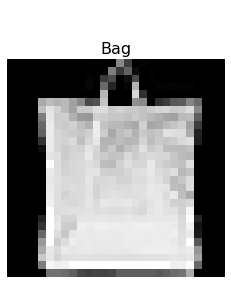

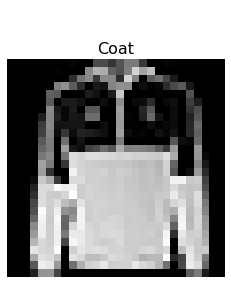

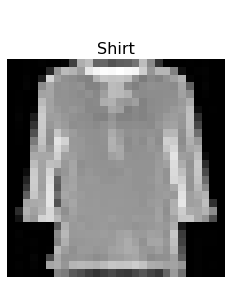

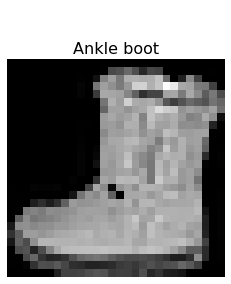

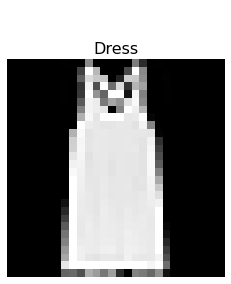

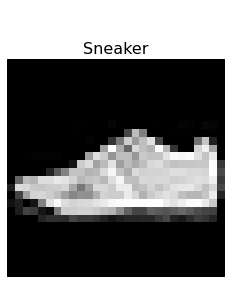

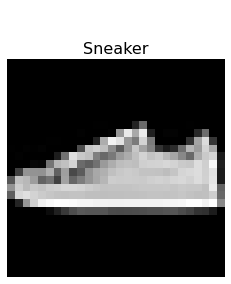

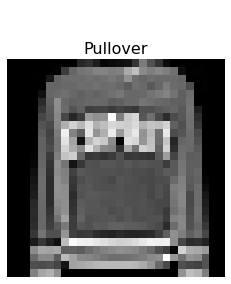

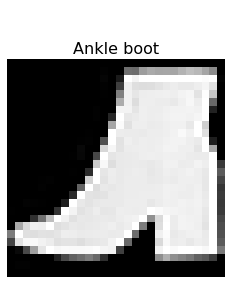

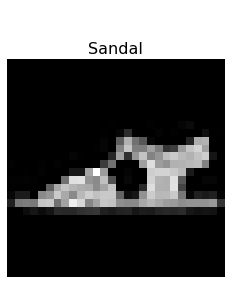

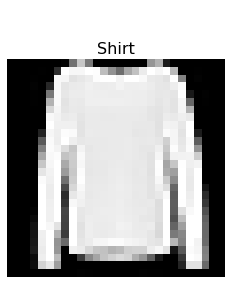

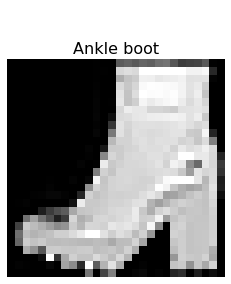

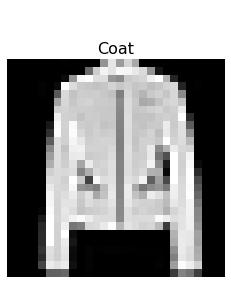

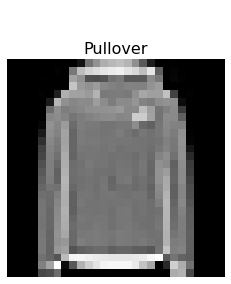

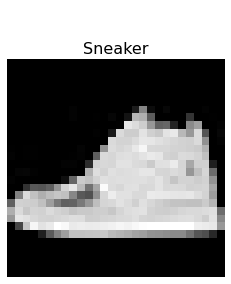

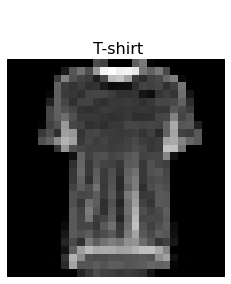

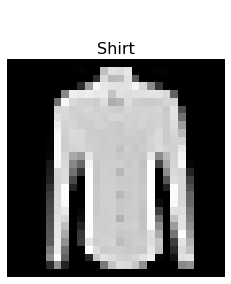

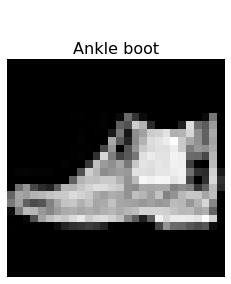

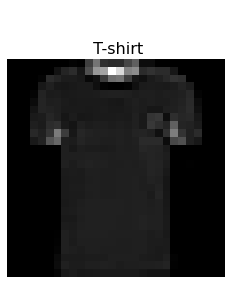

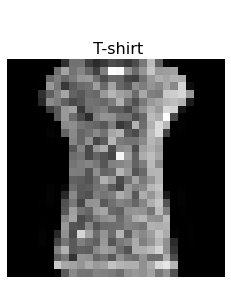

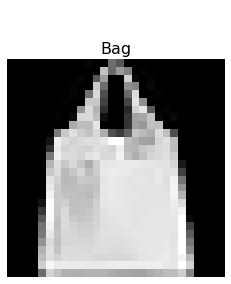

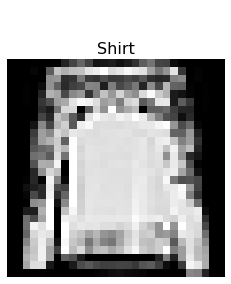

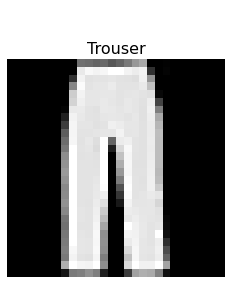

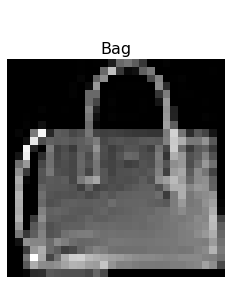

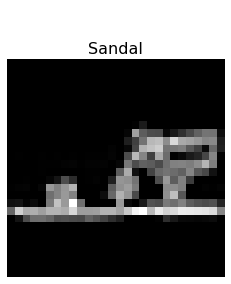

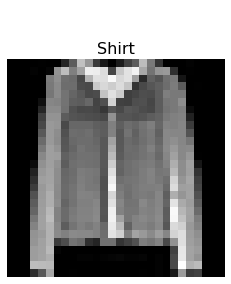

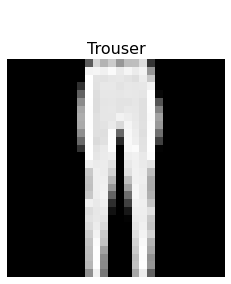

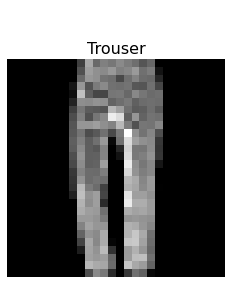

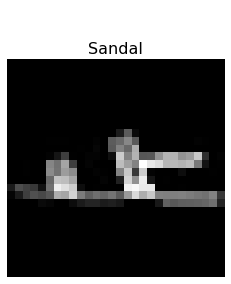

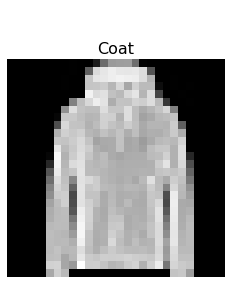

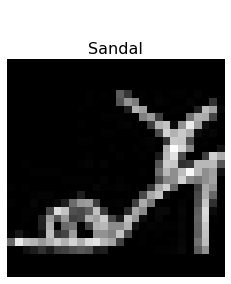

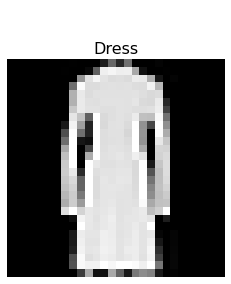

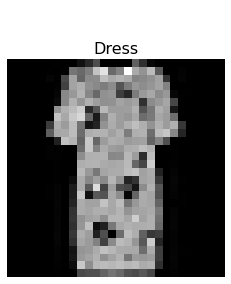

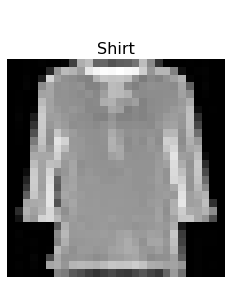

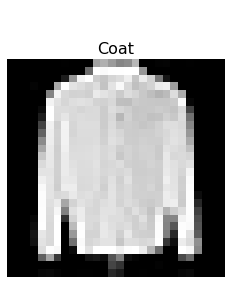

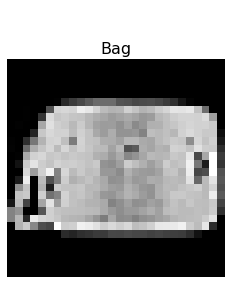

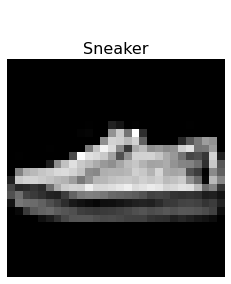

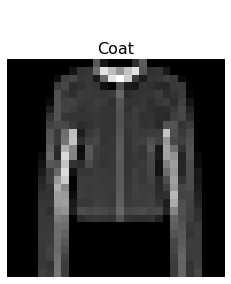

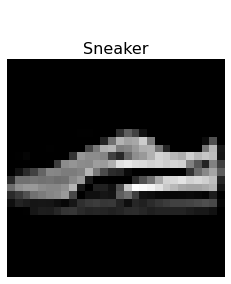

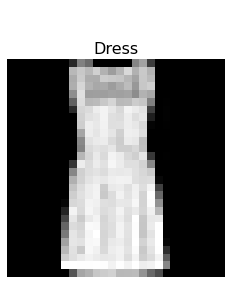

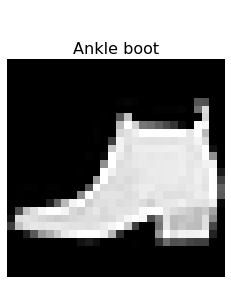

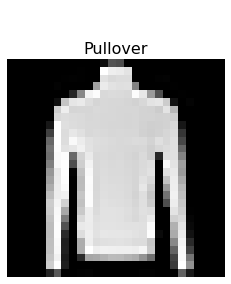

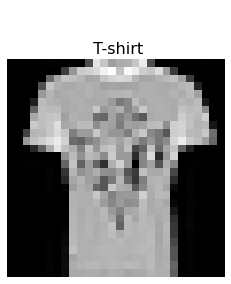

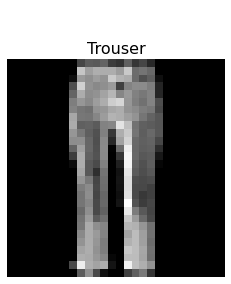

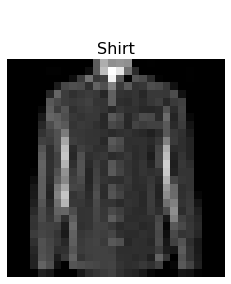

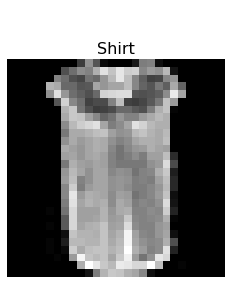

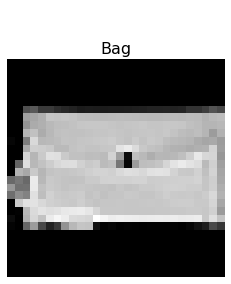

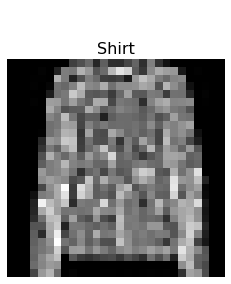

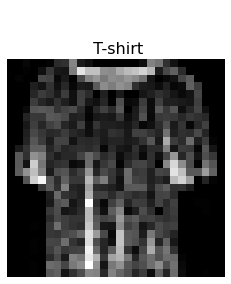

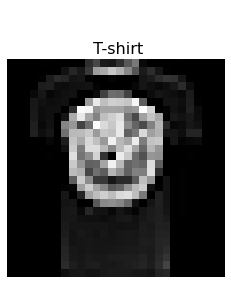

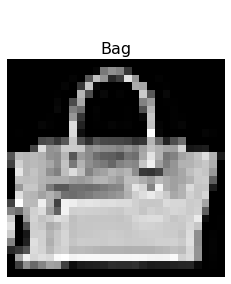

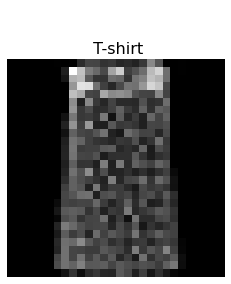

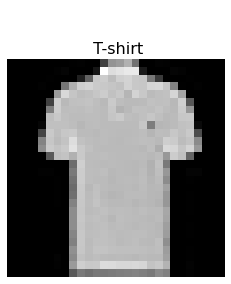

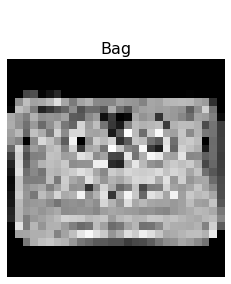

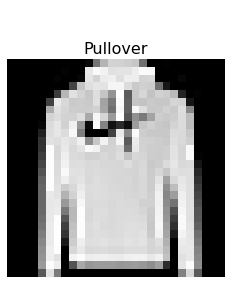

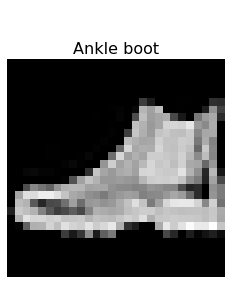

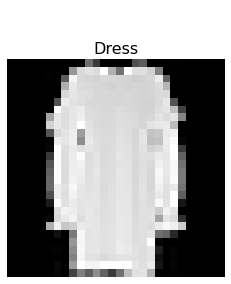

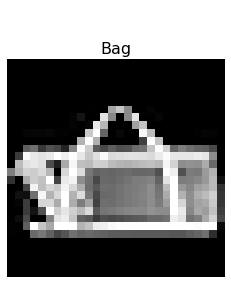

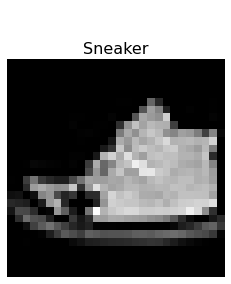

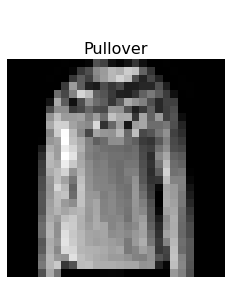

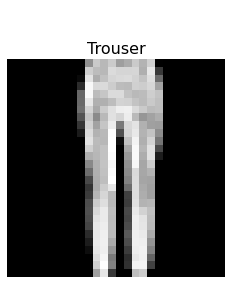

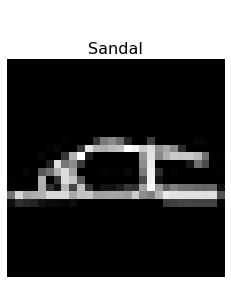

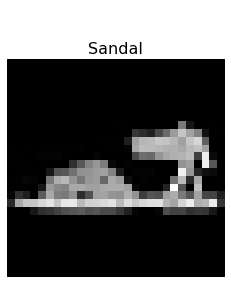

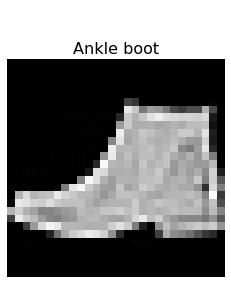

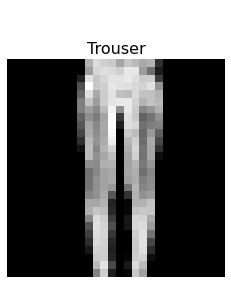

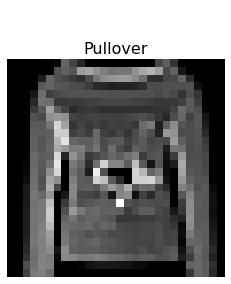

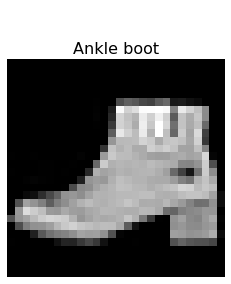

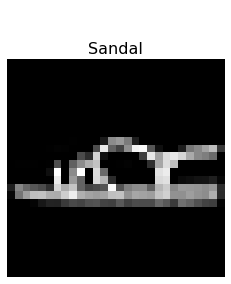

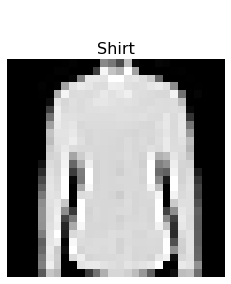

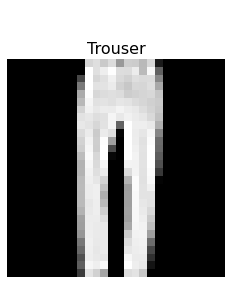

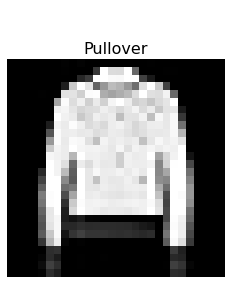

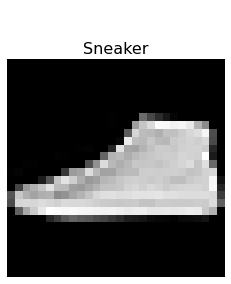

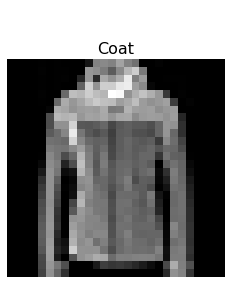

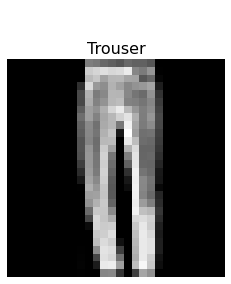

Error in callback <function flush_figures at 0x7fe6c5613378> (for post_execute):


KeyboardInterrupt: ignored

In [24]:
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [25]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

ConnectionError: ignored

In [26]:
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Flatten()(x)
x = Dense(K, activation='softmax')(x)

model2 = Model(i, x)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [27]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Epoch 1/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4786 - accuracy: 0.8335 - val_loss: 0.3936 - val_accuracy: 0.8643
Epoch 2/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3418 - accuracy: 0.8786 - val_loss: 0.3405 - val_accuracy: 0.8815
Epoch 3/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3016 - accuracy: 0.8934 - val_loss: 0.3337 - val_accuracy: 0.8790
Epoch 4/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2803 - accuracy: 0.8992 - val_loss: 0.3123 - val_accuracy: 0.8868
Epoch 5/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2626 - accuracy: 0.9057 - val_loss: 0.3071 - val_accuracy: 0.8889
Epoch 6/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2488 - accuracy: 0.9111 - val_loss: 0.3072 - val_accuracy: 0.8905
Epoch 7/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2359 - accuracy: 0.9160 - val_loss: 0.3032 - val_accuracy:

In [28]:
version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model2, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/2

INFO:tensorflow:Assets written to: /tmp/2/assets

Saved model:
total 84
drwxr-xr-x 2 root root  4096 Jul  6 19:01 assets
-rw-r--r-- 1 root root 77313 Jul  6 19:01 saved_model.pb
drwxr-xr-x 2 root root  4096 Jul  6 19:01 variables


In [29]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

ConnectionError: ignored

In [30]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/3:predict', data=data, headers=headers)
j = r.json()
print(j)

ConnectionError: ignored